In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import logging
from eden.util import configure_logging
configure_logging(logging.getLogger(), verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

In [2]:
from eden.util.NeedlemanWunsh import edit_distance

def select_best_match(motives, orig_motives):
    for i, orig_motif in enumerate(orig_motives):
        max_score = 0
        max_cluster_id = 0
        max_motif = None
        for cluster_id in motives:
            consensus_seq = motives[cluster_id]['consensus_seq']
            score = edit_distance(orig_motif, consensus_seq)
            score = 2 * float(score) / (len(orig_motif)+len(consensus_seq))
            if score > max_score:
                max_score = score
                max_cluster_id = cluster_id
        yield max_score, max_cluster_id

In [3]:
#code for making artificial dataset
import random
import  numpy as np

def random_string(length,alphabet_list):
    rand_str = ''.join(random.choice(alphabet_list) for i in range(length))
    return rand_str

def perturb(seed,alphabet_list,perturbation_prob=0.5):
    seq=''
    for c in seed:
        if random.random() < perturbation_prob: 
            c = random.choice(alphabet_list)
        seq += c
    return seq

def create_motives(alphabet='ACGU', motif_length=10):
    motives = []
    for character in alphabet:
        motif = [character]*motif_length
        motives.append(''.join(motif))
    return motives

def make_artificial_dataset(alphabet='ACGU', 
                            motif_length=10,
                            sequence_length=100, 
                            n_sequences=1000, 
                            n_motives=2, 
                            perturbation_prob=0.2):
    alphabet_list=[c for c in alphabet]
    motives = [random_string(motif_length, alphabet_list) for i in range(n_motives)]
        
    flanking_length = (sequence_length - motif_length ) / 2
    n_seq_per_motif = n_sequences / n_motives

    counter=0
    seqs=[]
    targets=[]
    for i in range(n_seq_per_motif):
        for j in range(n_motives):
            left_flanking = random_string(flanking_length,alphabet_list)
            right_flanking = random_string(flanking_length,alphabet_list)
            noisy_motif = perturb(motives[j],alphabet_list,perturbation_prob)
            seq = left_flanking + noisy_motif + right_flanking
            seqs.append(('ID_%.3d'%counter,seq))
            targets.append(j)
            counter += 1
    return seqs, np.array(targets), motives

In [4]:
motif_length=6
n_motives=3
sequence_length=90
n_sequences=500*n_motives
perturbation_prob=0.2
n_sequences_all=10000

all_seqs, targets, orig_motives = make_artificial_dataset('ACGU',motif_length,sequence_length,n_sequences_all,n_motives,perturbation_prob)
pos_seqs = all_seqs[:n_sequences] 
all_seqs = all_seqs[n_sequences:]

In [5]:
from eden.modifier.seq import seq_to_seq, shuffle_modifier
neg_seqs = seq_to_seq(pos_seqs, modifier=shuffle_modifier, times=2, order=1)
neg_seqs = list(neg_seqs)

In [6]:
complexity=3
n_clusters=n_motives*5
min_subarray_size=motif_length-2
max_subarray_size=motif_length+2
pos_size = len(pos_seqs)
neg_size = len(neg_seqs)
print 'Processing %d pos and %d neg' % (pos_size, neg_size)
import multiprocessing
n=multiprocessing.cpu_count()
pos_block_size = pos_size / n
neg_block_size = neg_size / n

Processing 1500 pos and 3000 neg


In [7]:
print 'motif_length:',motif_length
print 'n_motives:',n_motives
print 'sequence_length:',sequence_length
print 'n_sequences:',n_sequences
print 'perturbation_prob:',perturbation_prob

print 'n_clusters:',n_clusters
print 'min_subarray_size:',min_subarray_size
print 'max_subarray_size:',max_subarray_size
print 'pos block_size:',pos_block_size
print 'neg block_size:',neg_block_size

print
for motif in orig_motives: print motif

motif_length: 6
n_motives: 3
sequence_length: 90
n_sequences: 1500
perturbation_prob: 0.2
n_clusters: 15
min_subarray_size: 4
max_subarray_size: 8
pos block_size: 187
neg block_size: 375

AUGCGA
ACAGAA
UGAGCC


Examples:

Cluster: 0
AUGCGA UACGACUGGGCUGAUCGUUUUAUCCUCUAGUAAGACGACAGUAUGCGAUGGAGAAUUGUUUAAAAGUUGUCUUUUAAUUCCCACUCUUUA
AUACGA UUUAAGCUCCGAGGUUAGGGUAUGAGCGGUGAAAGUUAUAGCAUACGAUUCCUAUAGACGGUUGCAACGGCUCGGGAUGACAAAUCCGCC
AUGUGA UUUUGAGCACCAUCCUGUUGCAAAACACCGGCACGCCCGCUCAUGUGAAUGCACCGCUUUACGCGCCAUAAUCGUAAAGAUCCUAUCACG
UCGCGA CUGCCGGCCGGCUACCGAACCCUCGGCCGCAACCUCUGAGCCUCGCGAUGGGUGACGGACCUACGUCGGAGCACAUACGAACUGUUCGGA
AUGCGA UUGAGAGGGGCAUCCUAGGCCGCCUAAUGUCCAAUAUCUUCGAUGCGAGAUAGCGGCGCCCGGUCGUGACGUGACGAAGUACUACAUUCC
AUACGA CUUCACGCCCAGCAGGAUCAUAGCGGACCUACAUACGGGCUAAUACGAAAAACGACAGCGGUAACUGUCCCUUGUGCAGAAGUUGGGGUA

Cluster: 1
UCAGAA CACUGUGUGGAAGUUCUAUUGGUUCCGCGUCUUUGCAGAAUGUCAGAAGACCGAAUUCUUCAAUCACUCCUUCGGGCAACGAUACGCCUU
ACAGAA AGCUAGUCCCGUAUAAGGGGUCCCUAGUUCAAUCACCGAGCUACAGAAACCCAGGUGUGCUGGGUCGCGAUGAAGAUUUUGAUCCACAGU
ACACUA AGAUGUCUCCUGCCUACCUGACUGAAUCCUGGCUAGGAGCUCACACUAGGAGCCCACCGUGCGUGCAAACGUCCGAUUUAUCAGCAGACC
ACAUAA AACACUUCUUAGUGAGCUCAAUUUUCUUUCUCCUAAGACUGCACAUAAAGGCGGGACCAGAUUAUCUCUACCCACAU

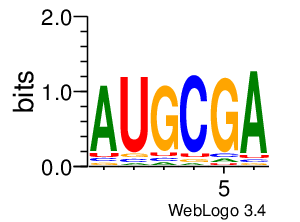

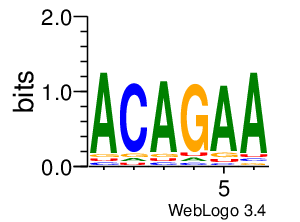

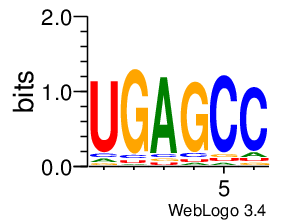

In [8]:
print 'Examples:'

max_chars=min(sequence_length/2,50)
for id_clus in range(n_motives):
    print 
    print 'Cluster: %d' % id_clus
    for i,( h,s) in enumerate(pos_seqs[:16]):
        id = i % n_motives
        if id == id_clus:
            print s[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2], 
            print s[sequence_length/2-max_chars:sequence_length/2+max_chars]

            
from collections import defaultdict

true_motives = defaultdict(list)
for i,( h,s) in enumerate(pos_seqs):
    id = i % n_motives
    true_motives[id].append((h,s[sequence_length/2-motif_length/2:sequence_length/2+motif_length/2]))
from eden.sequence_motif_decomposer import Weblogo
wl= Weblogo(resolution=200,stacks_per_line=60, sequence_type='rna')

for id in true_motives:
    logo = wl.create_logo(true_motives[id])
    from IPython.display import Image, display
    display(Image(logo))

Identified a total of 5 motives
Average score: 0.85


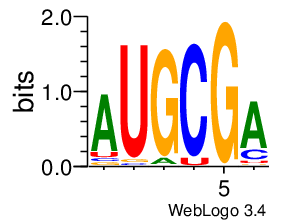

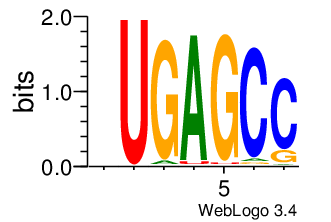

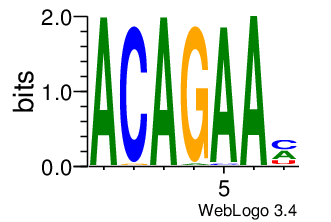

CPU times: user 991 ms, sys: 344 ms, total: 1.34 s
Wall time: 25.1 s


In [9]:
%%time
pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=pos_block_size,
          neg_block_size=neg_block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
motives = smod.select_motives(seqs=pos_seqs,
                                p_value=0.05,
                                similarity_th=0.5,
                                min_score=4,
                                min_freq=.5,
                                min_cluster_size=5,
                                regex_th=.3,
                                sample_size=200,
                                freq_th=None,
                                std_th=None)
print 'Identified a total of %d motives' % len(motives)
avg_score = np.mean([s for s,id in select_best_match(motives, orig_motives)])
print 'Average score: %.2f' % avg_score

selected = [id for s,id in select_best_match(motives, orig_motives)]
logos = smod.compute_logos(motives,ids=selected)
for id in logos:
    from IPython.display import Image, display
    display(Image(logos[id]))

# Full analysis

In [10]:
%%time

pos_size = len(pos_seqs)
train_pos_seqs = pos_seqs[:pos_size/2]
test_pos_seqs = pos_seqs[pos_size/2:]

neg_size = len(neg_seqs)
train_neg_seqs = neg_seqs[:neg_size/2]
test_neg_seqs = neg_seqs[neg_size/2:]

from eden.sequence_motif_decomposer import SequenceMotifDecomposer as SMoD
smod=SMoD(complexity=complexity,
          n_clusters=n_clusters,
          min_subarray_size=min_subarray_size,
          max_subarray_size=max_subarray_size,
          pos_block_size=pos_block_size,
          neg_block_size=neg_block_size)
smod = smod.fit(train_pos_seqs, train_neg_seqs)
smod.performance(test_pos_seqs, test_neg_seqs)
motives = smod.select_motives(seqs=pos_seqs,
                                p_value=0.05,
                                similarity_th=0.5,
                                min_score=4,
                                min_freq=.5,
                                min_cluster_size=5,
                                regex_th=.3,
                                sample_size=200,
                                freq_th=None,
                                std_th=None)

Confusion matrix:
[[1472   28]
 [ 683   65]]
Classification:
             precision    recall  f1-score   support

         -1       0.68      0.98      0.81      1500
          1       0.70      0.09      0.15       748

avg / total       0.69      0.68      0.59      2248

ROC: 0.652
CPU times: user 1.14 s, sys: 426 ms, total: 1.57 s
Wall time: 29.6 s


In [11]:
from IPython import display
display.Markdown(data=smod.report(pos_seqs, all_seqs, motives, fname='artificial_motif'))

### Summary: 4 motives
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_importance.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_importance.png" style="width: 100%"></p>
  - 2 AACAGAA
  - 1 GAUGCGA
  - 0 AUGAGCC
  - 13 GAGCCUU
#### Motif id: 2
  - num subarrays: 214
  - consensus sequence: AACAGAA
  - consensus regex: ACAGAA
  - num occurrences of regex: 211
  - freq of occurrences of regex: 0.14
  - average location: 45.0 +- 0.0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_logo_cl_2.png"></p>
<p align="left"><img src="artificial_motif_logo_cl_2.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_loc_2.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_loc_2.png" style="width: 100%"></p>
  - num co-occurences 2 GAGCCUU vs 0 UGAGCC: 10
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_2_vs_0.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_2_vs_0.png" style="width: 100%"></p>
  - num co-occurences 2 GAGCCUU vs 1 AUGCGA: 12
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_2_vs_1.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_2_vs_1.png" style="width: 100%"></p>
  - num co-occurences 2 GAGCCUU vs 13 GAGCCUU: 0
____________________________________________________________________________________________________
#### Motif id: 1
  - num subarrays: 291
  - consensus sequence: GAUGCGA
  - consensus regex: AUGCGA
  - num occurrences of regex: 209
  - freq of occurrences of regex: 0.14
  - average location: 45.0 +- 0.0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_logo_cl_1.png"></p>
<p align="left"><img src="artificial_motif_logo_cl_1.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_loc_1.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_loc_1.png" style="width: 100%"></p>
  - num co-occurences 1 GAGCCUU vs 0 UGAGCC: 21
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_1_vs_0.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_1_vs_0.png" style="width: 100%"></p>
  - num co-occurences 1 GAGCCUU vs 2 ACAGAA: 12
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_1_vs_2.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_1_vs_2.png" style="width: 100%"></p>
  - num co-occurences 1 GAGCCUU vs 13 GAGCCUU: 2
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_1_vs_13.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_1_vs_13.png" style="width: 100%"></p>
____________________________________________________________________________________________________
#### Motif id: 0
  - num subarrays: 245
  - consensus sequence: AUGAGCC
  - consensus regex: UGAGCC
  - num occurrences of regex: 208
  - freq of occurrences of regex: 0.14
  - average location: 45.0 +- 0.0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_logo_cl_0.png"></p>
<p align="left"><img src="artificial_motif_logo_cl_0.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_loc_0.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_loc_0.png" style="width: 100%"></p>
  - num co-occurences 0 GAGCCUU vs 1 AUGCGA: 21
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_0_vs_1.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_0_vs_1.png" style="width: 100%"></p>
  - num co-occurences 0 GAGCCUU vs 2 ACAGAA: 10
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_0_vs_2.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_0_vs_2.png" style="width: 100%"></p>
  - num co-occurences 0 GAGCCUU vs 13 GAGCCUU: 1
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_0_vs_13.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_0_vs_13.png" style="width: 100%"></p>
____________________________________________________________________________________________________
#### Motif id: 13
  - num subarrays: 10
  - consensus sequence: GAGCCUU
  - consensus regex: GAGCCUU
  - num occurrences of regex: 25
  - freq of occurrences of regex: 0.02
  - average location: 46.0 +- 0.0
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_logo_cl_13.png"></p>
<p align="left"><img src="artificial_motif_logo_cl_13.png"></p>
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_loc_13.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_loc_13.png" style="width: 100%"></p>
  - num co-occurences 13 GAGCCUU vs 0 UGAGCC: 1
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_13_vs_0.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_13_vs_0.png" style="width: 100%"></p>
  - num co-occurences 13 GAGCCUU vs 1 AUGCGA: 2
<p align="left"><img src="file:///Users/costa/Desktop/BTSync/Projects/EDeN/examples_EDeN/bioinf/motif/artificial_motif_dist_13_vs_1.png" style="width: 100%"></p>
<p align="left"><img src="artificial_motif_dist_13_vs_1.png" style="width: 100%"></p>
  - num co-occurences 13 GAGCCUU vs 2 ACAGAA: 0
____________________________________________________________________________________________________

---